# Import Libraries

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve 
from sklearn.metrics import make_scorer

#from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures, SelectBySingleFeaturePerformance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import joblib


In [ ]:
# set paths
DATAPATH = "./data"
Path(DATAPATH).mkdir(parents=True, exist_ok=True)

print('The working directory is: ', os.getcwd())

The working directory is:  h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\Customer_Analytics\CreditDefaultPrediction


# Helper Functions

In [ ]:
def get_na_pct_df(df)->pd.DataFrame:
    """Return percentages of Nas for each column in df """
    nrows = df.shape[0]
    return pd.DataFrame(df.isna().sum() / nrows, columns=['na_pct'])

def get_featurelist_above_na_threshold(na_df, na_threshold = 0.1):
    # get features above na threshold
    column_name = na_df.columns[0]
    return list(na_df[na_df[column_name] > na_threshold].index)

def validate_model(X_train, y_train, algorithm:str):
  """ Input training data and the name of the ml-algo e.g. 'lgbm', 'xgb', 'rf', 'linear'. 
      Outputs the cross validation results 
       """
  # instantiate model
  if algorithm=='lgbm':
    model = LGBMClassifier()
  elif algorithm=='xgb':
    model = XGBClassifier()
  elif algorithm=='rf':
    model = RandomForestClassifier()
  elif algorithm=='linear':
    model = LogisticRegression(max_iter=100000)
  else:
    print('Enter correct algorithm name')  
  
  # define validation metrics
  scoring = {'accuracy': make_scorer(accuracy_score),
          'recall': make_scorer(recall_score),
          'precision': make_scorer(precision_score),
          'roc_auc': make_scorer(roc_auc_score)
          }
  # cross validate model; choose only 3 folds due to little data
  scores = cross_validate(model, 
                          X_train, 
                          y_train,
                          scoring=scoring, 
                          cv=3)
  # print cross validation 
  print('------------------Cross Validation Results: ------------------\n', 
        'Algorithm used: ', algorithm, '\n')
  
  print('Accuracy: {:.1f} % +/- {:.1f} % (cross validated)'.format(scores['test_accuracy'].mean()*100, scores['test_accuracy'].std()*100))
  print('Recall: {:.1f} % +/- {:.1f} % (cross validated)'.format(scores['test_recall'].mean()*100, scores['test_recall'].std()*100))
  print('Precision: {:.1f} % +/- {:.1f} % (cross validated)'.format(scores['test_precision'].mean()*100, scores['test_precision'].std()*100))
  print('ROC-AUC: {:.1f} % +/- {:.1f} % (cross validated)'.format(scores['test_roc_auc'].mean()*100, scores['test_roc_auc'].std()*100))
  print('____________________________________________\n\n\n')

def train_best_model(X_train, y_train, X_test, y_test, algorithm:str):
  """ Input training and testing data and the name of the ml-algo e.g. 'lgbm', 'xgb', 'rf', 'linear'. Outputs the trained model, the confusion matrix and the positive class probability scores"""
  # instantiate model
  if algorithm=='lgbm':
    model = LGBMClassifier()
  elif algorithm=='xgb':
    model = XGBClassifier()
  elif algorithm=='rf':
    model = RandomForestClassifier()
  elif algorithm=='linear':
    model = LogisticRegression(max_iter=100000)
  else:
    print('Enter correct algorithm name')  
  # fit model
  model.fit(X_train, y_train)
  # make prediction
  pred = model.predict(X_test)
  # get class probability scores
  nph_prob = model.predict_proba(X_test)
  # make confusion matrix
  mcm = confusion_matrix(y_test, pred)

  print('------------------Fitting Results: ------------------\n', 
        'Algorithm used: ', algorithm, '\n')

  print('------------------Confusion Matrix: ------------------\n', 
        mcm, '\n')

  print('------------------Classification Report: ------------------\n', 
        classification_report(y_test, pred), '\n')

  print('------------------Average AUC: ------------------\n', 
        roc_auc_score(y_test, nph_prob[:,1]), '\n')
  print('____________________________________________\n\n\n')
  
  return model, mcm, nph_prob

def plot_confusion_matrix(confusionmatrix):
  """ Input confusion matrix outputed by the check_model function """
  fig = plt.figure(figsize=(8,8))
  clv_classes = ['no credit default', 'credit default']
  plt.imshow(confusionmatrix, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(len(clv_classes))
  plt.xticks(tick_marks, clv_classes, rotation=45)
  plt.yticks(tick_marks, clv_classes)
  plt.xlabel("credit default predicted")
  plt.ylabel("actual credit default state")
  return fig

def plot_roc(y_test, pred_probab):
  """ Plot ROC based on actual labels e.g. y_test and predicted probabilies """
  fig = plt.figure(figsize=(8,8))
  clv_classes = ['no credit default', 'credit default']

  fpr, tpr, thresh = roc_curve(y_test, pred_probab[:,1], pos_label=1)
      
  # Plot the ROC chart
  plt.plot(fpr, tpr, linestyle='--',color='red', label=clv_classes[1])
  plt.title('ROC Curve')
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.legend()
  plt.grid('on')
  return fig

def plot_recall_precision(y_test, pred_probab):
  """ Plot recall-precision curve based on actual labels e.g. y_test and predicted probabilies """
  fig = plt.figure(figsize=(8,8))
  clv_classes = ['no credit default', 'credit default']
  
  precision, recall, thresh = precision_recall_curve(y_test, pred_probab[:,1], pos_label=1)
      
  # Plot the ROC chart
  plt.plot(recall, precision, linestyle='--',color='red', label=clv_classes[1])
  plt.title('Recall-Precision Curve')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.grid('on')
  return fig      

# Dataset Preparation

In [ ]:
df = pd.read_csv(DATAPATH + '/loan_default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [ ]:
# show data dimensions
df.shape

(148670, 34)

In [ ]:
# show data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
df.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

after data inspection let´s change the feature term to type string and drop the feature dtir1 in the last column 

In [ ]:
# change feature term to type string
df['term'] = df['term'].astype('str')

# drop last column
df.drop(columns=['dtir1'], axis=1, inplace=True)

## drop features with too many null values

In [ ]:
# check percentages of nas in each columns
na_df = get_na_pct_df(df)
na_df

,na_pct
ID,0.000000
year,0.000000
loan_limit,0.022493
Gender,0.000000
approv_in_adv,0.006107
loan_type,0.000000
loan_purpose,0.000901
Credit_Worthiness,0.000000
open_credit,0.000000
business_or_commercial,0.000000


In [ ]:
# get feature list above na-threshold
na_features = get_featurelist_above_na_threshold(na_df)
print('features with too many NAs', na_features)

# drop features above na-threshold 
df.drop(columns=na_features, inplace=True)

features with too many NAs ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV']


In [ ]:
# check percentages of nas in each columns
na_df = get_na_pct_df(df)
na_df

,na_pct
ID,0.000000
year,0.000000
loan_limit,0.022493
Gender,0.000000
approv_in_adv,0.006107
loan_type,0.000000
loan_purpose,0.000901
Credit_Worthiness,0.000000
open_credit,0.000000
business_or_commercial,0.000000


## categorize features into numeric and categorical

In [ ]:
# seperate into numerical and categorical features
num_features = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index[2:-1])
cat_features = list(df.dtypes[df.dtypes == 'object'].index)
label = ['Status']
print('-----------------------------------')
print('numeric features: \n', num_features)
print('-----------------------------------')
print('categorical features: \n', cat_features) 

-----------------------------------
numeric features: 
 ['loan_amount', 'income', 'Credit_Score']
-----------------------------------
categorical features: 
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


# Exploratory Data Analysis

## EDA on numeric features

In [ ]:
# explore numeric columns
df[num_features + label].describe()

,loan_amount,income,Credit_Score,Status
count,1.486700e+05,139520.000000,148670.000000,148670.000000
mean,3.311177e+05,6957.338876,699.789103,0.246445
std,1.839093e+05,6496.586382,115.875857,0.430942
min,1.650000e+04,0.000000,500.000000,0.000000
25%,1.965000e+05,3720.000000,599.000000,0.000000
50%,2.965000e+05,5760.000000,699.000000,0.000000
75%,4.365000e+05,8520.000000,800.000000,0.000000
max,3.576500e+06,578580.000000,900.000000,1.000000


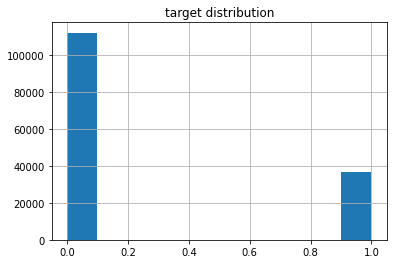

In [ ]:
# show target distribution
df[label].hist()
plt.title('target distribution')
plt.show()

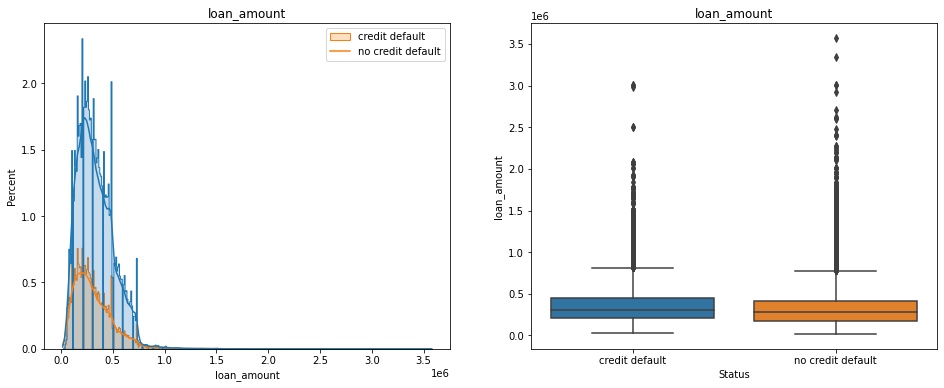

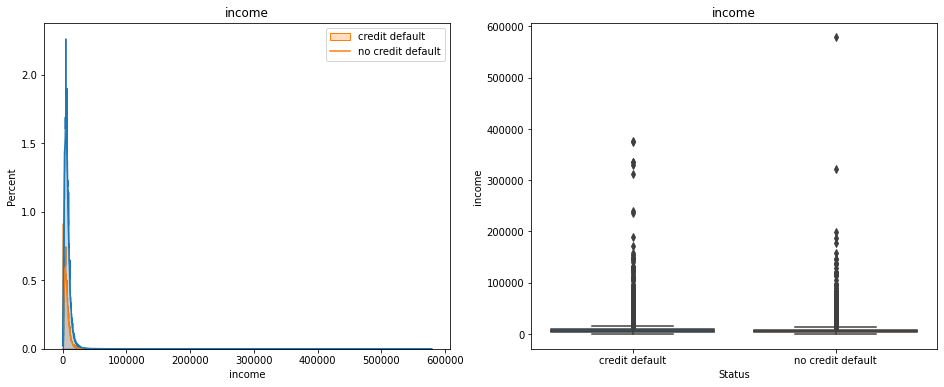

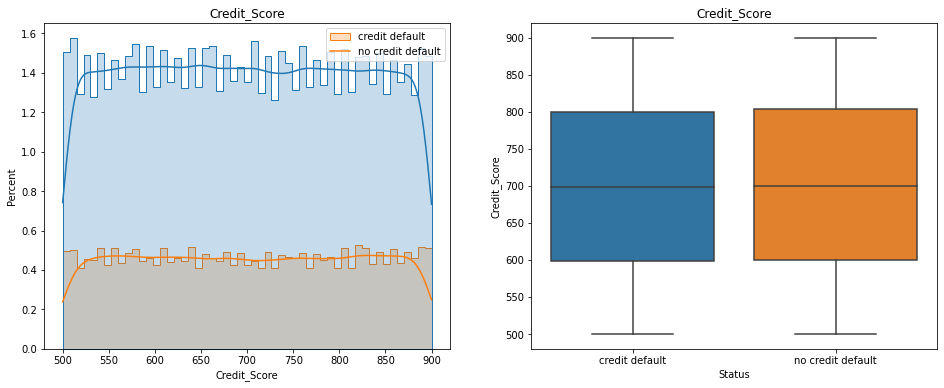

In [ ]:
# plot distributions of numeric features
for col in num_features:
  try:
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    
    sns.histplot(data=df, 
                 x=col, 
                 hue='Status', 
                 stat='percent', 
                 kde=True,
                 element='step',
                 ax=ax[0])
    ax[0].set_title(col)
    ax[0].legend(['credit default', 'no credit default'])

    sns.boxplot(data=df, 
                y=col, 
                x='Status',
                ax=ax[1])
    ax[1].set_title(col)
    ax[1].set_xticklabels(['credit default', 'no credit default'])

    plt.show()
  except:
    print('Singular matrix error due to constant feature value')

In [ ]:
# lets replace outliers in income and loan_amount with median
df['income'][df['income']>40000] = df['income'].median()
df['loan_amount'][df['loan_amount']>500000] = df['loan_amount'].median() 

C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\2436621645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'][df['income']>40000] = df['income'].median()
C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\2436621645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_amount'][df['loan_amount']>500000] = df['loan_amount'].median()


## EDA on categorical features

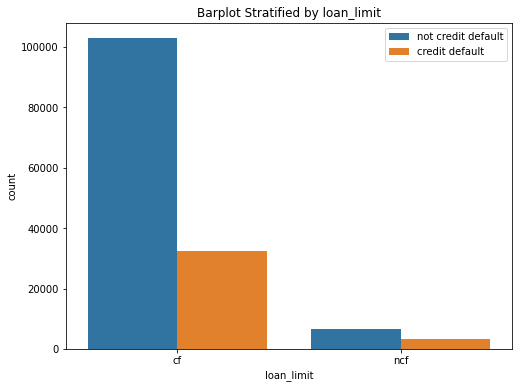

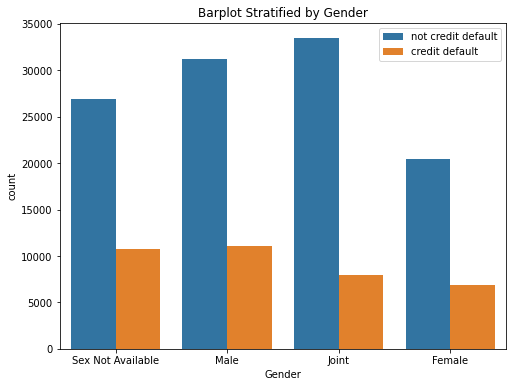

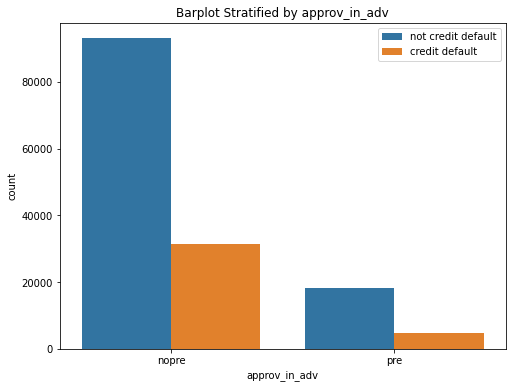

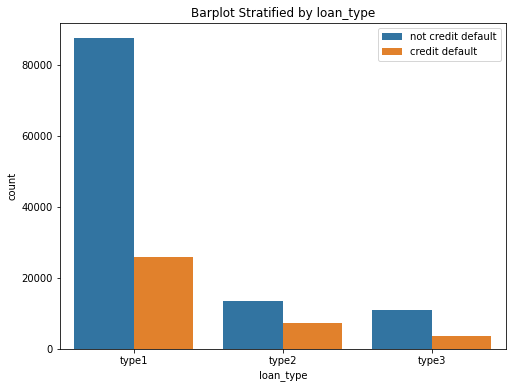

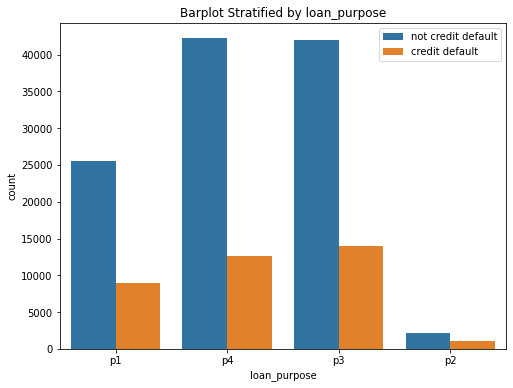

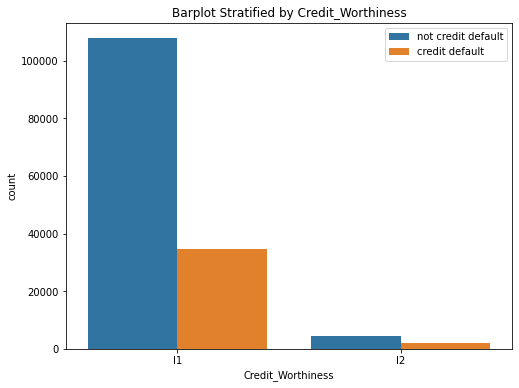

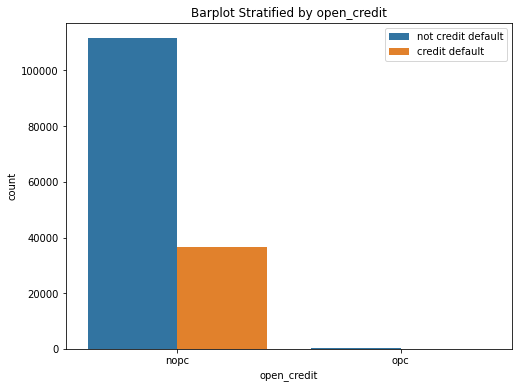

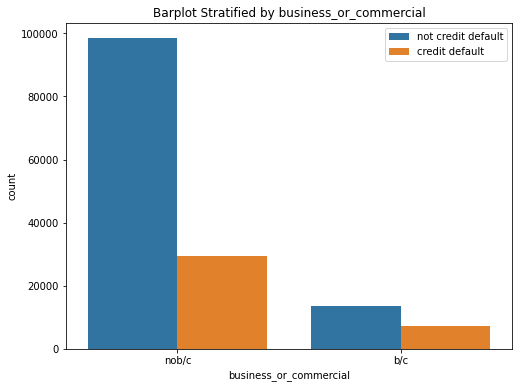

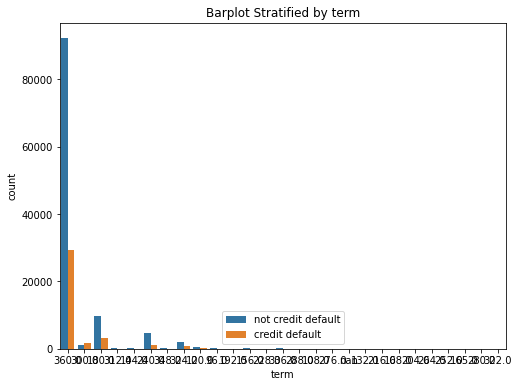

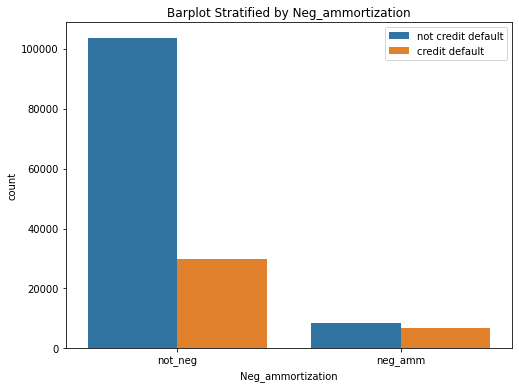

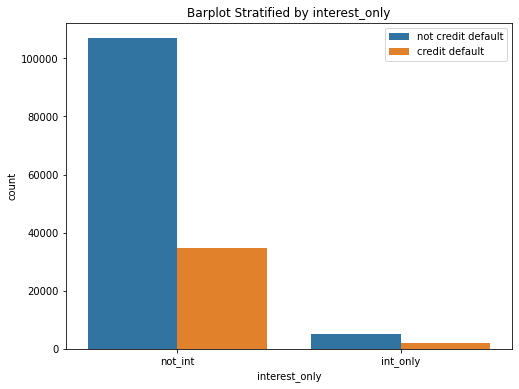

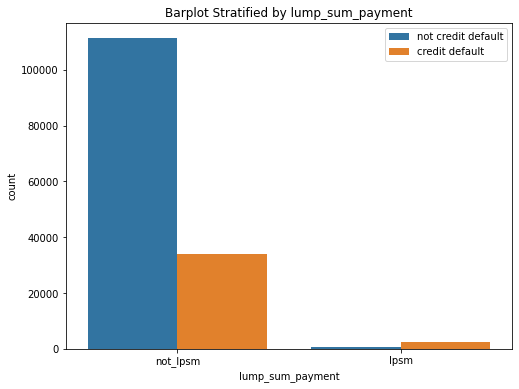

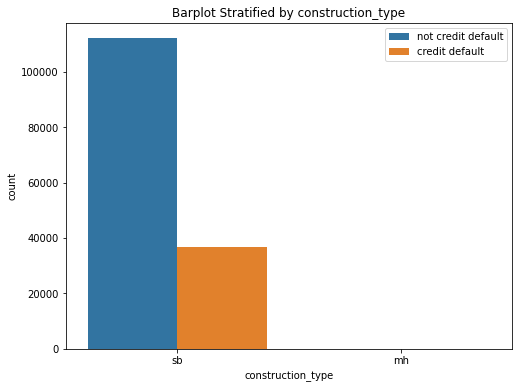

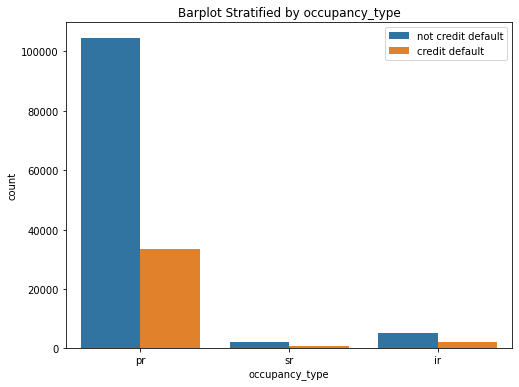

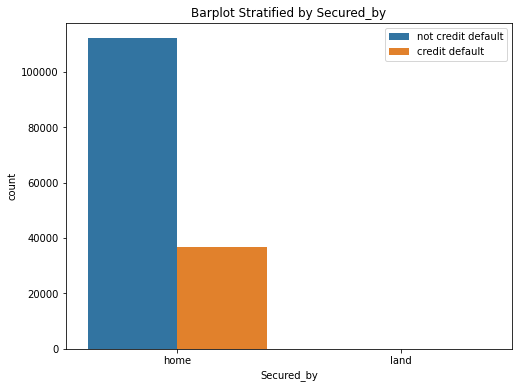

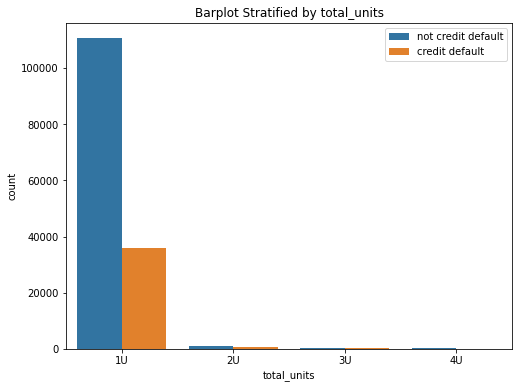

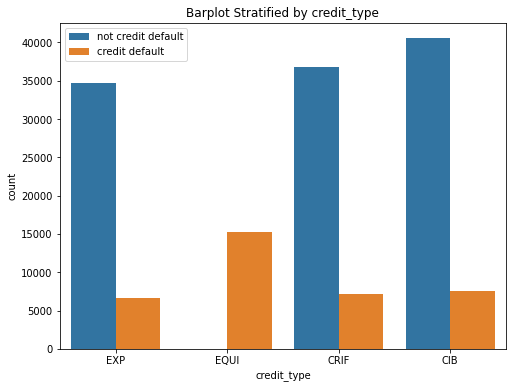

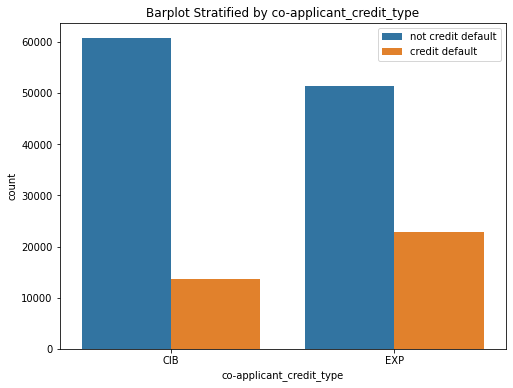

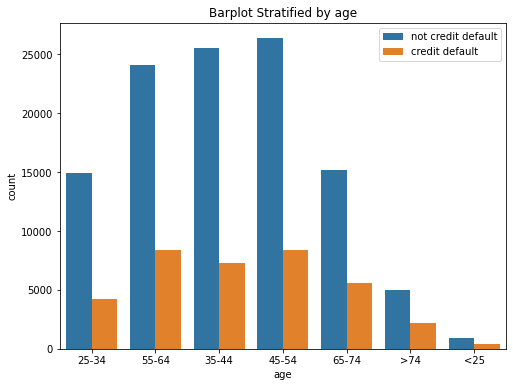

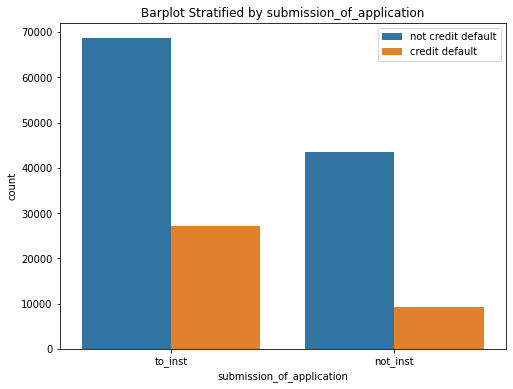

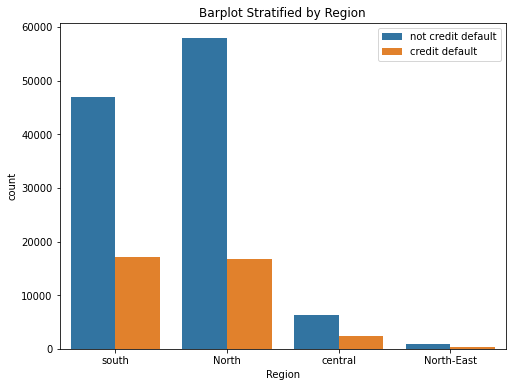

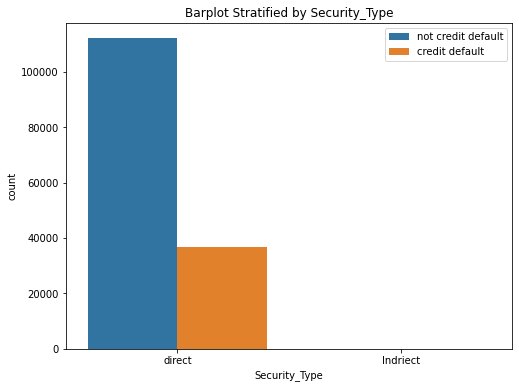

In [ ]:
# show distribution of categorical features
for feat in cat_features:
  fig, ax = plt.subplots(figsize=(8,6))
  ax = sns.countplot(x=feat, hue="Status", data=df, ax=ax)
  ax.set_title('Barplot Stratified by '+feat)
  ax.legend(['not credit default', 'credit default'])
  plt.show()

In [ ]:
# we see that many features have only one major cat and the rest very rare categories; so we can drop those feautures without information loss
cat_features_to_drop = ['open_credit', 'term', 'lump_sum_payment', 'construction_type', 'Secured_by', 'total_units', 'Security_Type', 'occupancy_type']

df.drop(columns = cat_features_to_drop,
        axis = 1,
        inplace = True)         

In [ ]:
# update cat_feature list
for feat in cat_features_to_drop: 
    cat_features.remove(feat)

# Train-Test Split

In [ ]:
# Separate into train and test sets
X = df[num_features + cat_features]
y = df[label].values.reshape(-1)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.3, stratify=y, random_state=123)


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((104069, 17), (104069,), (44601, 17), (44601,))

## Impute missing data

In [ ]:
# impute numeric data
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train[num_features] = imp.fit_transform(X_train[num_features])
X_test[num_features] = imp.transform(X_test[num_features])

# impute categorical data
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train[cat_features] = imp.fit_transform(X_train[cat_features]) 
X_test[cat_features] = imp.transform(X_test[cat_features])

C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\2659741747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = imp.fit_transform(X_train[num_features])
C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\2659741747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[num_features] = imp.transform(X_test[num_features])
C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\2659741747.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

## Hote-Encode Categorical Data

In [ ]:
# hotencode categorical features
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_enc = pd.DataFrame(enc.fit_transform(X_train[cat_features]), columns=enc.get_feature_names()) 
X_test_enc = pd.DataFrame(enc.transform(X_test[cat_features]), columns=enc.get_feature_names())
X_test_enc.head()

,x0_cf,x0_ncf,x1_Female,x1_Joint,x1_Male,x1_Sex Not Available,x2_nopre,x2_pre,x3_type1,x3_type2,...,x11_55-64,x11_65-74,x11_<25,x11_>74,x12_not_inst,x12_to_inst,x13_North,x13_North-East,x13_central,x13_south
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Feature Scaling

In [ ]:
# scale numeric features
scaler = MinMaxScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\1959150850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = scaler.fit_transform(X_train[num_features])
C:\Users\Sebas\AppData\Local\Temp\ipykernel_26896\1959150850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[num_features] = scaler.transform(X_test[num_features])


In [ ]:
# put all transformed datasets together
X_train = pd.concat([X_train[num_features].reset_index(drop=True), X_train_enc.reset_index(drop=True)], axis=1) 
X_test = pd.concat([X_test[num_features].reset_index(drop=True), X_test_enc.reset_index(drop=True)], axis=1)

In [32]:
X_train

,index,loan_amount,income,Credit_Score,index,x0_cf,x0_ncf,x1_Female,x1_Joint,x1_Male,...,x11_55-64,x11_65-74,x11_<25,x11_>74,x12_not_inst,x12_to_inst,x13_North,x13_North-East,x13_central,x13_south
0,53849,0.583333,0.142643,0.0400,0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,14950,0.583333,0.163664,0.7075,1,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,84229,0.875000,0.211712,0.9975,2,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,102160,0.416667,0.076577,0.2325,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35798,0.729167,0.103604,0.5775,4,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104064,102928,0.937500,0.144144,0.6500,104064,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
104065,126246,0.416667,0.235736,0.0575,104065,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
104066,57516,0.583333,0.276276,0.7850,104066,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
104067,3340,0.104167,0.043544,0.8425,104067,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Modeling

In [29]:
# find best ml-model using cross validation
validate_model(X_train, y_train, 'linear')
validate_model(X_train, y_train, 'lgbm')
validate_model(X_train, y_train, 'rf')

C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------Cross Validation Results: ------------------
 Algorithm used:  linear 

Accuracy: 75.4 % +/- 0.0 % (cross validated)
Recall: 0.0 % +/- 0.0 % (cross validated)
Precision: 0.0 % +/- 0.0 % (cross validated)
ROC-AUC: 50.0 % +/- 0.0 % (cross validated)
____________________________________________





C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\Sebas\anaconda3\envs\pycaretenv\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\Sebas\anaconda3\envs\pycarete

------------------Cross Validation Results: ------------------
 Algorithm used:  lgbm 

Accuracy: nan % +/- nan % (cross validated)
Recall: nan % +/- nan % (cross validated)
Precision: nan % +/- nan % (cross validated)
ROC-AUC: nan % +/- nan % (cross validated)
____________________________________________



------------------Cross Validation Results: ------------------
 Algorithm used:  rf 

Accuracy: 86.3 % +/- 0.1 % (cross validated)
Recall: 47.7 % +/- 0.8 % (cross validated)
Precision: 93.8 % +/- 1.5 % (cross validated)
ROC-AUC: 73.3 % +/- 0.3 % (cross validated)
____________________________________________





In [30]:
# train model on training data and validate model on test data
model, mcm, default_prob = train_best_model(X_train, y_train, X_test, y_test, algorithm='lgbm')

LightGBMError: Feature (index) appears more than one time.

# Model Evaluation

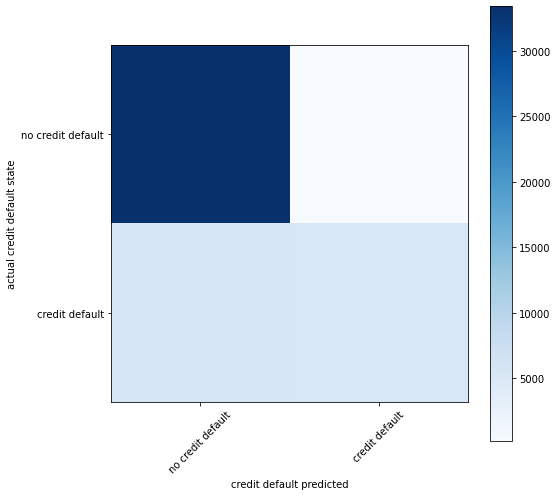

In [ ]:
# plot confusion matrix
fig = plot_confusion_matrix(mcm)

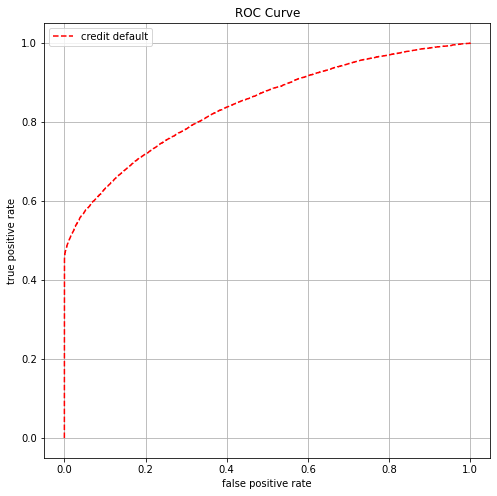

In [ ]:
# plot roc curve
fig = plot_roc(y_test, default_prob)

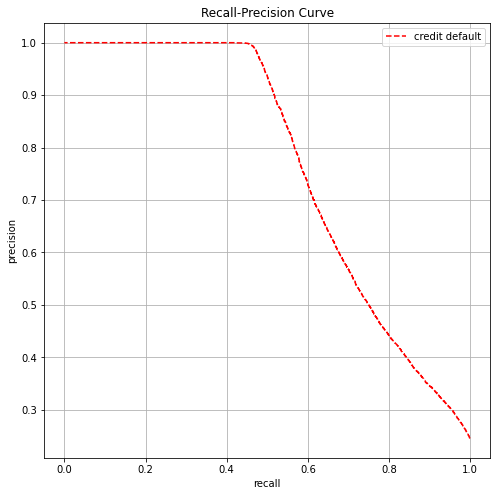

In [ ]:
# plot precision-recall curve
fig = plot_recall_precision(y_test, default_prob)